## Predicción con *Regresión Logística Multinomial* como modelo predictivo para predecir si un equipo local gana, empata o pierde

In [ ]:
% pip install -r requirements.txt

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
df = pd.read_csv("outputs/partidos_con_clima_completo.csv")
print(df.dtypes)

Local                   object
Visitante               object
Estadio                 object
Longitud               float64
Latitud                float64
                        ...   
Temperatura_C          float64
Sensacion_Termica_C    float64
Precipitacion_mm       float64
Viento_kmh             float64
Codigo_Clima           float64
Length: 127, dtype: object


In [10]:
# Definimos variables que no se conocen antes del partido o que contienen información del resultado
leakage_cols = [
    'FTR', 'FTHG', 'FTAG',  # Resultado final    
    'HTHG', 'HTAG', 'HTR', # Información al descanso
    'HS', 'AS', 'HST', 'AST', # Estadísticas del partido
    'HC', 'AC', 'HF', 'AF',
    'HO', 'AO', 'HY', 'AY',
    'HR', 'AR', 'HBP', 'ABP',
    'Asistencia', 'Referee', # Información posterior al partido
    "Date", "Time", "Estadio" # Información no relevante para el modelo
]

# Eliminamos las variables de leakage y variable objetivo
X = df.drop(columns=[c for c in leakage_cols if c in df.columns]) 

# Identificamos las columnas numéricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist() 

# Rellenar los valores vacíos en las columnas numéricas con la media del equipo local
X[num_cols] = X.groupby('Local')[num_cols].transform(lambda x: x.fillna(x.mean())) 

# Seleccionamos columnas de cuotas y probabilidades que necesitamos
odds_cols = [
    col for col in X.columns
    if any(book in col for book in [
        'B365', 'BW', 'WH', 'PS', 'BF', 'Avg', 'Max', '1XBH', '1XBD', '1XBA', 'P>2.5', 'P<2.5', 'PAHH', 'PAHA','PC>2.5', 'PC<2.5', 'BWA'
    ])
]

# Convertimos todas las columnas de odds a numérico (si hay errores, se ponen NaN)
for col in odds_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Rellenamos los valores vacíos en odds por la media del equipo local
X[odds_cols] = X.groupby('Local')[odds_cols].transform(lambda x: x.fillna(x.mean()))

# Relleno de seguridad: si quedan NaN, rellenamos por la media global
X[odds_cols] = X[odds_cols].fillna(X[odds_cols].mean())
X[num_cols] = X[num_cols].fillna(X[num_cols].mean())

# Identificamos las columnas categóricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Convertimos las variables categóricas a dummies (drop_first=True para evitar multicolinealidad)
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Variable objetivo convertida a categoría
y = df['FTR'].astype('category')

In [11]:
# Dividimos el conjunto de datos en 3 subconjuntos: Train (60%), Val (20%) y Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Escalamos los datos
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Tamaño de los subconjuntos de datos
print("Tamaño Train:", X_train.shape)
print("Tamaño Validation:", X_val.shape)
print("Tamaño Test:", X_test.shape)

Tamaño Train: (228, 141)
Tamaño Validation: (76, 141)
Tamaño Test: (76, 141)


In [17]:
# Definimos la función para realizar la regresión logística y calcular la métrica de error F1-score
def logistic_f1(X_train, y_train, X_val, y_val, features):
    """
    Ajustamos el modelo de regresión logística y devolvemos el F1-score en el conjunto de validación.
    features es la lista de predictores.
    """
    # NOTA: En scikit-learn >= 1.5, multi_class='multinomial' es el comportamiento por defecto
    # para problemas multiclase, por lo que no es necesario especificarlo
    model = LogisticRegression(
        solver='lbfgs', max_iter=500
    )
    model.fit(X_train[features], y_train)
    y_pred = model.predict(X_val[features])
    f1 = f1_score(y_val, y_pred, average='weighted')
    return f1, model

In [18]:
# Dado que el conjunto de datos es grande, hacemos una selección progresiva hacia adelante (forward selection) para elegir las mejores variables para 
# el modelo de regresión logística.
def forward_selection_reg_models(X_train, y_train, X_val, y_val, base_features):
    """
    Realizamos la selección progresiva hacia adelante partiendo de un modelo base (base_features), no del modelo nulo (modelo que no 
    contiene ninguna variable). Solo se seleccionan de manera progresiva las columnas restantes.
    """
    remaining = [c for c in X_train.columns if c not in base_features]
    selected = base_features.copy()  
    best_models = {}

    while remaining:
        scores = []
        for col in remaining:
            f1, model = logistic_f1(X_train, y_train, X_val, y_val, selected + [col])
            scores.append((f1, col, model))

        # Tomamos la variable que da mayor F1-score
        best_f1, best_col, best_model = max(scores, key=lambda x: x[0])
        selected.append(best_col)
        remaining.remove(best_col)
        best_models[len(selected)] = (best_f1, best_model, selected.copy())
        print(f"Forward step {len(selected)}: add {best_col} => F1={best_f1:.4f}")

    return best_models

In [19]:
# Seleccionamos las variables dummies (las variables de equipos local y visitante) como base del modelo.
dummies = [c for c in X.columns if c.startswith("Local_") or c.startswith("Visitante_")]
forward_reg_models = forward_selection_reg_models(X_train, y_train, X_val, y_val, base_features = dummies)

Forward step 39: add AHCh => F1=0.5203
Forward step 40: add MaxAHA => F1=0.5455
Forward step 41: add Longitud => F1=0.5455
Forward step 42: add Latitud => F1=0.5455
Forward step 43: add BWD => F1=0.5455
Forward step 44: add PCAHA => F1=0.5580
Forward step 45: add BFECAHH => F1=0.5686
Forward step 46: add WHD => F1=0.5701
Forward step 47: add WHCD => F1=0.5698
Forward step 48: add AvgCD => F1=0.5791
Forward step 49: add BWCD => F1=0.5802
Forward step 50: add MaxCH => F1=0.5804
Forward step 51: add BFA => F1=0.5686
Forward step 52: add AHh => F1=0.5662
Forward step 53: add B365C>2.5 => F1=0.5802
Forward step 54: add B365<2.5 => F1=0.5802
Forward step 55: add PC>2.5 => F1=0.5802
Forward step 56: add AvgCAHH => F1=0.5803
Forward step 57: add MaxC>2.5 => F1=0.5803
Forward step 58: add AvgC>2.5 => F1=0.5803
Forward step 59: add PSA => F1=0.5698
Forward step 60: add MaxA => F1=0.5698
Forward step 61: add 1XBA => F1=0.5687
Forward step 62: add AvgD => F1=0.5630
Forward step 63: add 1XBCH => F1

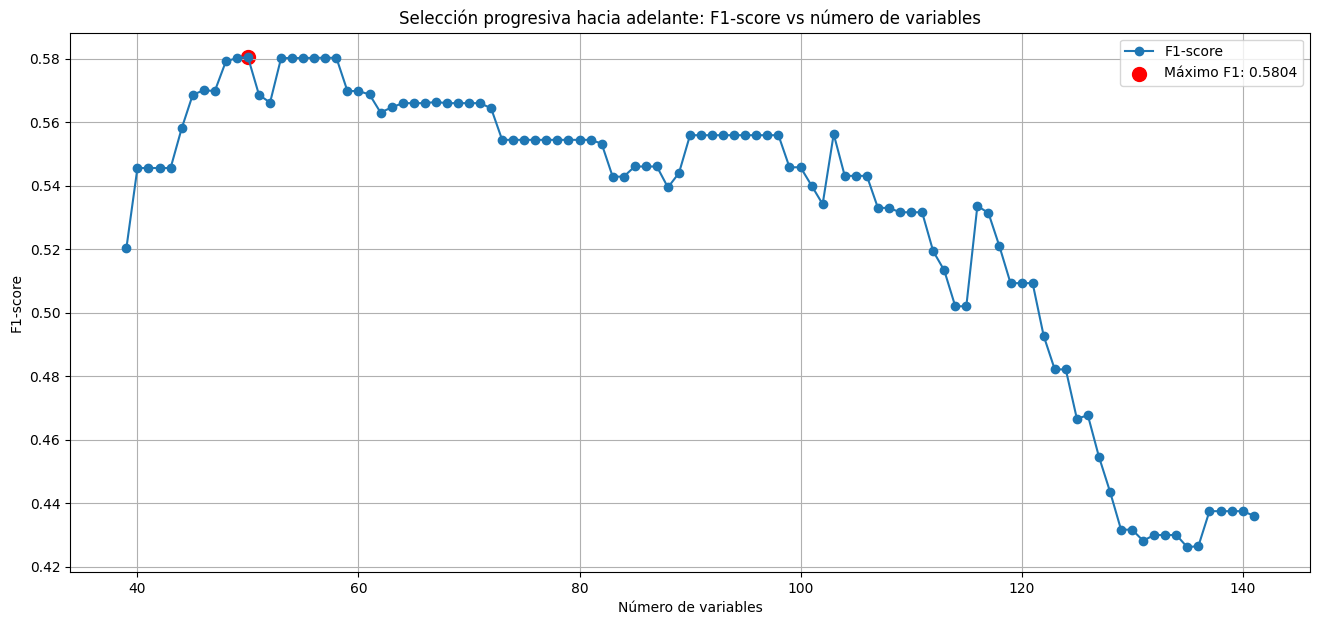

In [20]:
# Hacemos una lista con el número de variables y otra con los F1-score de cada modelo
n_vars = []
f1_scores = []

for n, (f1, model, variables) in forward_reg_models.items():
    n_vars.append(len(variables))  # Número total de variables en el modelo
    f1_scores.append(f1)

n_vars = np.array(n_vars)
f1_scores = np.array(f1_scores)

# Encontramos el F1-score máximo
max_idx = np.argmax(f1_scores)
max_n = n_vars[max_idx]
max_f1 = f1_scores[max_idx]

# Graficamos los F1-score de cada modelo en función del número de variables, destacando aquel modelo que tiene mayor F1-score
plt.figure(figsize=(16,7))
plt.plot(n_vars, f1_scores, marker='o', label='F1-score')
plt.scatter(max_n, max_f1, color='red', s=100, label=f'Máximo F1: {max_f1:.4f}')
plt.xlabel('Número de variables')
plt.ylabel('F1-score')
plt.title('Selección progresiva hacia adelante: F1-score vs número de variables')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
# Encuentramos el número de variables que da el mayor F1
best_forward_num_vars = max(forward_reg_models.keys(), key=lambda k: forward_reg_models[k][0])
best_forward_f1, best_forward_model, best_forward_features = forward_reg_models[best_forward_num_vars]

print(f"Mejor F1-score: {best_forward_f1}")
print(f"Número de variables en el modelo: {best_forward_num_vars}")
print(f"Variables explicativas del mejor modelo:\n{best_forward_features}")

Mejor F1-score: 0.5804318488529014
Número de variables en el modelo: 50
Variables explicativas del mejor modelo:
['Local_Atlético de Madrid', 'Local_CA Osasuna        ', 'Local_CD Leganés        ', 'Local_Deportivo Alavés  ', 'Local_FC Barcelona      ', 'Local_Getafe CF         ', 'Local_Girona FC         ', 'Local_RC Celta          ', 'Local_RCD Espanyol      ', 'Local_RCD Mallorca      ', 'Local_Rayo Vallecano    ', 'Local_Real Betis        ', 'Local_Real Madrid       ', 'Local_Real Sociedad     ', 'Local_Real Valladolid   ', 'Local_Sevilla FC        ', 'Local_UD Las Palmas     ', 'Local_Valencia CF       ', 'Local_Villarreal CF     ', 'Visitante_Atlético de Madrid', 'Visitante_CA Osasuna        ', 'Visitante_CD Leganés        ', 'Visitante_Deportivo Alavés  ', 'Visitante_FC Barcelona      ', 'Visitante_Getafe CF         ', 'Visitante_Girona FC         ', 'Visitante_RC Celta          ', 'Visitante_RCD Espanyol      ', 'Visitante_RCD Mallorca      ', 'Visitante_Rayo Vallecano    ', 'V

In [22]:
# Definimos la función para realizar la selección progresiva hacia atrás
def backward_selection_reg_models(X_train, y_train, X_val, y_val, keep_features):
    """
    Realizamos la selección progresiva hacia atrás con restricciones.
    keep_features es lista de columnas que nunca se eliminan.
    """
    selected = list(X_train.columns)  # Empezamos con todas las variables
    best_models = {}

    while True:
        scores = []
        for col in selected:
            # No consideramos eliminar las variables "fijas"
            if col in keep_features:
                continue
            temp_features = selected.copy()
            temp_features.remove(col)
            if not temp_features:
                continue
            f1, model = logistic_f1(X_train, y_train, X_val, y_val, temp_features)
            scores.append((f1, col, model, temp_features))

        if not scores:  # Ya no hay variables eliminables
            break

        # Eliminamos la variable cuya eliminación mejora F1
        best_f1, worst_col, best_model, best_features = max(scores, key=lambda x: x[0])
        selected = best_features
        best_models[len(selected)] = (best_f1, best_model, selected.copy())
        print(f"Backward step {len(selected)+1} -> remove {worst_col} => F1={best_f1:.4f}")

    return best_models

In [23]:
# Seleccionamos las variables dummies (las variables de equipos local y visitante) como variables que nunca se eliminan.
dummies = [c for c in X.columns if c.startswith("Local_") or c.startswith("Visitante_")]
backward_reg_models = backward_selection_reg_models(X_train, y_train, X_val, y_val, keep_features = dummies)

Backward step 141 -> remove B365CAHA => F1=0.4524
Backward step 140 -> remove PCAHA => F1=0.4648
Backward step 139 -> remove MaxAHH => F1=0.4665
Backward step 138 -> remove PCAHH => F1=0.4722
Backward step 137 -> remove BFCD => F1=0.4744
Backward step 136 -> remove BFECAHA => F1=0.4847
Backward step 135 -> remove MaxAHA => F1=0.4871
Backward step 134 -> remove PAHH => F1=0.5016
Backward step 133 -> remove B365AHA => F1=0.5113
Backward step 132 -> remove B365D => F1=0.5125
Backward step 131 -> remove Longitud => F1=0.5125
Backward step 130 -> remove B365A => F1=0.5125
Backward step 129 -> remove BWD => F1=0.5125
Backward step 128 -> remove BFH => F1=0.5125
Backward step 127 -> remove BFA => F1=0.5125
Backward step 126 -> remove Latitud => F1=0.5125
Backward step 125 -> remove B365H => F1=0.5125
Backward step 124 -> remove BWA => F1=0.5125
Backward step 123 -> remove BFD => F1=0.5125
Backward step 122 -> remove PSH => F1=0.5125
Backward step 121 -> remove PSD => F1=0.5125
Backward step 1

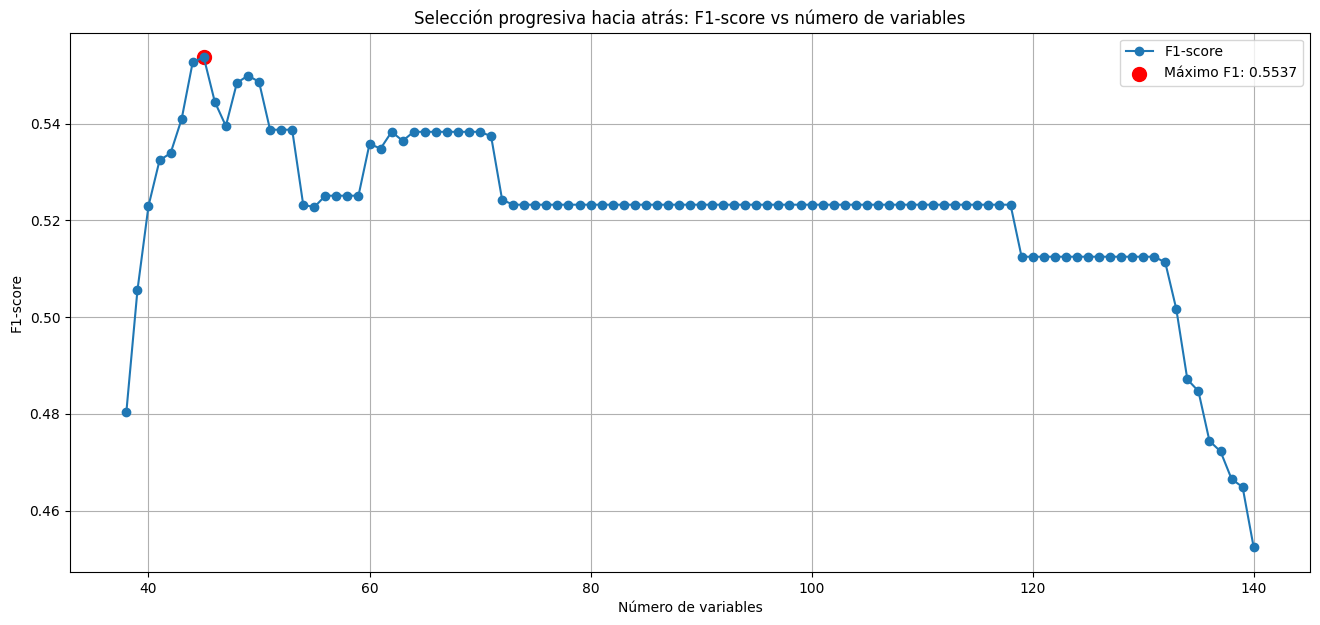

In [24]:
# Hacemos una lista con el número de variables y otra con los F1-score de cada modelo
n_vars = []
f1_scores = []

for n, (f1, model, variables) in backward_reg_models.items():
    n_vars.append(len(variables))  # Número total de variables en el modelo
    f1_scores.append(f1)

n_vars = np.array(n_vars)
f1_scores = np.array(f1_scores)

# Encontramos el índice del F1-score máximo
max_idx = np.argmax(f1_scores)
max_n = n_vars[max_idx]
max_f1 = f1_scores[max_idx]

# Graficamos los F1-score de cada modelo en función del número de variables, destacando aquel modelo que tiene mayor F1-score
plt.figure(figsize=(16,7))
plt.plot(n_vars, f1_scores, marker='o', label='F1-score')
plt.scatter(max_n, max_f1, color='red', s=100, label=f'Máximo F1: {max_f1:.4f}')
plt.xlabel('Número de variables')
plt.ylabel('F1-score')
plt.title('Selección progresiva hacia atrás: F1-score vs número de variables')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Encuentramos el número de variables que da el mayor F1-score
best_backward_num_vars = max(backward_reg_models.keys(), key=lambda k: backward_reg_models[k][0])
best_backward_f1, best_backward_model, best_backward_features = backward_reg_models[best_backward_num_vars]

print(f"Mejor F1-score: {best_backward_f1}")
print(f"Número de variables en el modelo: {best_backward_num_vars}")
print(f"Variables explicativas del mejor modelo:\n{best_backward_features}")

Mejor F1-score: 0.5537193432876157
Número de variables en el modelo: 45
Variables explicativas del mejor modelo:
['AvgAHH', '1XBCD', 'BFECH', 'MaxCAHA', 'Sensacion_Termica_C', 'Precipitacion_mm', 'Viento_kmh', 'Local_Atlético de Madrid', 'Local_CA Osasuna        ', 'Local_CD Leganés        ', 'Local_Deportivo Alavés  ', 'Local_FC Barcelona      ', 'Local_Getafe CF         ', 'Local_Girona FC         ', 'Local_RC Celta          ', 'Local_RCD Espanyol      ', 'Local_RCD Mallorca      ', 'Local_Rayo Vallecano    ', 'Local_Real Betis        ', 'Local_Real Madrid       ', 'Local_Real Sociedad     ', 'Local_Real Valladolid   ', 'Local_Sevilla FC        ', 'Local_UD Las Palmas     ', 'Local_Valencia CF       ', 'Local_Villarreal CF     ', 'Visitante_Atlético de Madrid', 'Visitante_CA Osasuna        ', 'Visitante_CD Leganés        ', 'Visitante_Deportivo Alavés  ', 'Visitante_FC Barcelona      ', 'Visitante_Getafe CF         ', 'Visitante_Girona FC         ', 'Visitante_RC Celta          ', 'V

In [26]:
# Hacemos una tabla comparando el F1-score de validación para el mejor modelo de cada tipo

table = pd.DataFrame([
    {
        'Tipo de modelo': 'Selección progresiva hacia adelante',
        'Mejor F1-score': best_forward_f1,
        'Número de variables': best_forward_num_vars
    },
    {
        'Tipo de modelo': 'Selección progresiva hacia atrás',
        'Mejor F1-score': best_backward_f1,
        'Número de variables': best_backward_num_vars
    }
])

print(table)

                        Tipo de modelo  Mejor F1-score  Número de variables
0  Selección progresiva hacia adelante        0.580432                   50
1     Selección progresiva hacia atrás        0.553719                   45


In [27]:
# -----------------------------
# Selección progresiva hacia adelante
# -----------------------------

# Predicciones sobre el conjunto de prueba
y_pred_forward = best_forward_model.predict(X_test[best_forward_features])

# F1-score en test
f1_test_forward = f1_score(y_test, y_pred_forward, average='weighted')
print(f"Forward selection - F1-score en test: {f1_test_forward}")

# -----------------------------
# Mejor modelo Backward
# -----------------------------

# Predicciones sobre el conjunto de prueba
y_pred_backward = best_backward_model.predict(X_test[best_backward_features])

# F1-score en test
f1_test_backward = f1_score(y_test, y_pred_backward, average='weighted')
print(f"Backward selection - F1-score en test: {f1_test_backward}")


Forward selection - F1-score en test: 0.41848437939769206
Backward selection - F1-score en test: 0.46820498296202484


## Predicción con *Random Forest*  como modelo predictivo para predecir la asistencia a un partido

In [30]:
df1 = pd.read_csv("outputs/partidos_con_clima_completo.csv")

# Nos asegurarnos de que 'Date' sea tipo datetime
df1["Date"] = pd.to_datetime(df1["Date"], dayfirst=True)

# Extraemos el día de la semana y lo convertimos a códigos numéricos (0 = Lunes,..., 6 = Domingo)
df1["Dia_Semana_Num"] = df1["Date"].dt.weekday

# Extraemos también el mes y lo convertimos a códigos numéricos (1 = Enero,..., 12 = Diciembre)
df1["Mes_Num"] = df1["Date"].dt.month

# Extraemos si es fin de semana o no (Sábado = 5, Domingo = 6)
df1["Finde"] = df1["Date"].dt.weekday.isin([5, 6]).astype(int)

# Codificamos Equipos y Estadio como categorías (a partir de códigos numéricos)
df1["Local_Num"] = df1["Local"].astype("category").cat.codes
df1["Visitante_Num"] = df1["Visitante"].astype("category").cat.codes
df1["Estadio_Num"] = df1["Estadio"].astype("category").cat.codes

In [31]:
# Definimos variables que no se conocen antes del partido o que contienen información del resultado
leakage_cols = [
    'FTR', 'FTHG', 'FTAG',  # Resultado final    
    'HTHG', 'HTAG', 'HTR', # Información al descanso
    'HS', 'AS', 'HST', 'AST', # Estadísticas del partido
    'HC', 'AC', 'HF', 'AF',
    'HO', 'AO', 'HY', 'AY',
    'HR', 'AR', 'HBP', 'ABP',
    "Asistencia",'Referee', # Información posterior al partido
    "Date", "Time", "Estadio", "Local", "Visitante" # Información no relevante para el modelo
]

# Eliminamos las variables de leakage y variable objetivo
X = df1.drop(columns=[c for c in leakage_cols if c in df1.columns]) 

# Identificamos las columnas numéricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist() 

# Rellenar los valores vacíos en las columnas numéricas con la media del equipo local
X[num_cols] = X.groupby('Local_Num')[num_cols].transform(lambda x: x.fillna(x.mean())) 

# Seleccionamos columnas de cuotas y probabilidades que necesitamos
odds_cols = [
    col for col in X.columns
    if any(book in col for book in [
        'B365', 'BW', 'WH', 'PS', 'BF', 'Avg', 'Max', '1XBH', '1XBD', '1XBA', 'P>2.5', 'P<2.5', 'PAHH', 'PAHA','PC>2.5', 'PC<2.5', 'BWA'
    ])
]

# Convertimos todas las columnas de odds a numérico (si hay errores, se ponen NaN)
for col in odds_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Rellenamos los valores vacíos en odds por la media del equipo local
X[odds_cols] = X.groupby('Local_Num')[odds_cols].transform(lambda x: x.fillna(x.mean()))

# Relleno de seguridad: si quedan NaN, rellenamos por la media global
X[odds_cols] = X[odds_cols].fillna(X[odds_cols].mean())
X[num_cols] = X[num_cols].fillna(X[num_cols].mean())

# Variable objetivo
y = df1['Asistencia']

In [32]:
# Dividimos el conjunto de datos en 2 subconjuntos: Train (75%) y Test (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Tamaño de los subconjuntos de datos
print("Tamaño Train:", X_train.shape)
print("Tamaño Test:", X_test.shape)

Tamaño Train: (285, 109)
Tamaño Test: (95, 109)


In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ajustamos un modelo de Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Entrenamos el modelo
rf.fit(X_train, y_train)

# Realizamos predicciones sobre el conjunto de test
y_pred = rf.predict(X_test)

# Evaluamos el modelo sobre el conjunto de test
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Evaluación del Modelo ---")
print(f"MAE: {mae} personas")
print(f"RMSE: {mse} personas")
print(f"R²: {r2}")

--- Evaluación del Modelo ---
MAE: 3208.8777894736845 personas
RMSE: 48085473.05538842 personas
R²: 0.8464289615861502


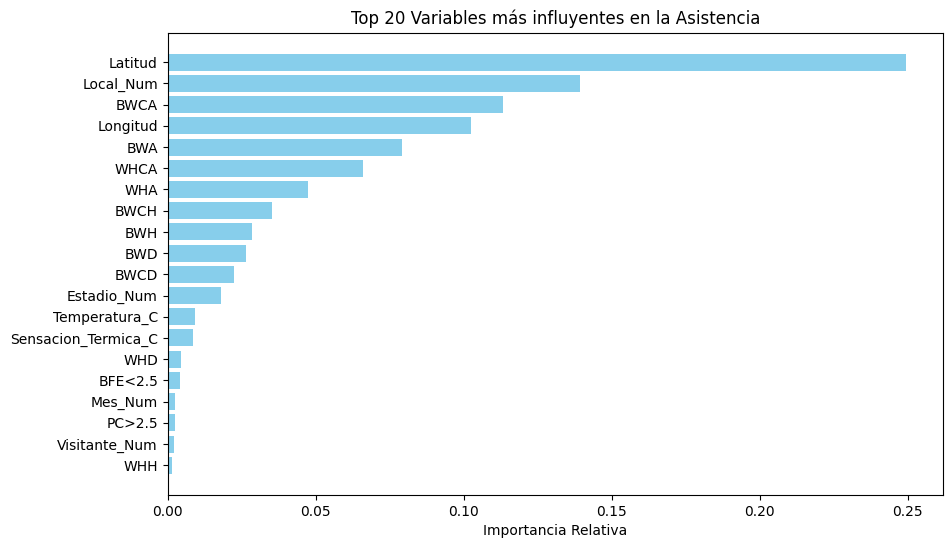

In [34]:
# Visualizamos la importancia de las variables
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Enseñamos las 20 más importantes

plt.figure(figsize=(10, 6))
plt.title("Top 20 Variables más influyentes en la Asistencia")
plt.barh(range(len(indices)), importances[indices], color="skyblue", align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importancia Relativa")
plt.show()

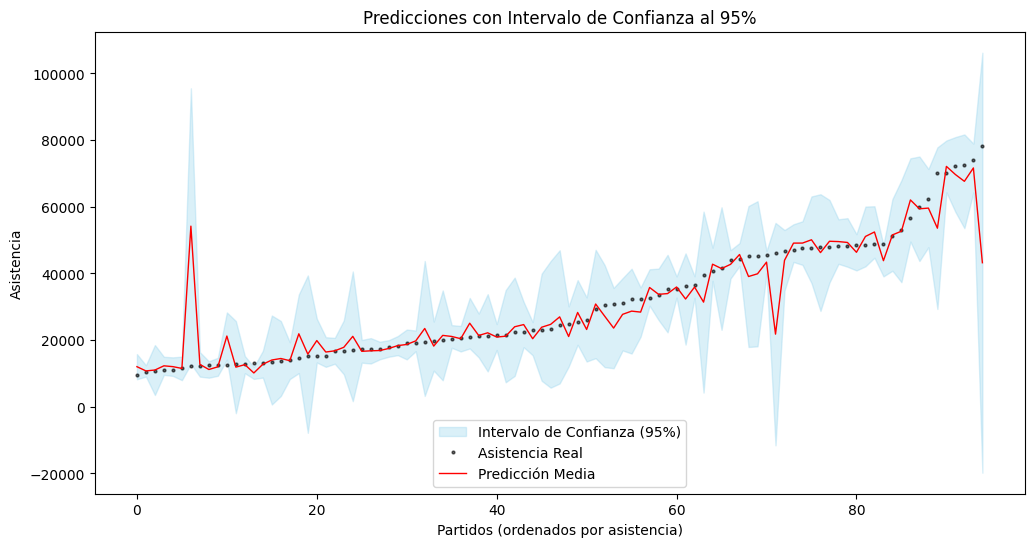

In [35]:
# Calculamos el intervalo de confianza al 95% de las predicciones basado en la varianza entre los árboles del bosque

# Obtener las predicciones de cada árbol individual (son 100 árboles)
# Para ello, usamos rf.estimators_, ya que contiene cada árbol entrenado
per_tree_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])

# Calculamos la media y la desviación típica de esas predicciones
y_mean = np.mean(per_tree_preds, axis=0)
y_std = np.std(per_tree_preds, axis=0)

# Graficamos los valores reales y las predicciones con el intervalo de confianza
idx = np.argsort(y_test.values)
y_test_sorted = y_test.values[idx]
y_mean_sorted = y_mean[idx]
y_std_sorted = y_std[idx]

plt.figure(figsize=(12, 6))
plt.fill_between(range(len(y_test_sorted)), 
                 y_mean_sorted - 2 * y_std_sorted, 
                 y_mean_sorted + 2 * y_std_sorted, 
                 color="skyblue", alpha=0.3, label="Intervalo de Confianza (95%)")

plt.plot(range(len(y_test_sorted)), y_test_sorted, "k.", markersize=4, label="Asistencia Real", alpha=0.6)
plt.plot(range(len(y_test_sorted)), y_mean_sorted, "red", label="Predicción Media", linewidth=1)
plt.title("Predicciones con Intervalo de Confianza al 95%")
plt.xlabel("Partidos (ordenados por asistencia)")
plt.ylabel("Asistencia")
plt.legend()
plt.show()